In [47]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import numpy as np
from sklearn import linear_model

In [48]:
%matplotlib inline
from pandas.plotting import scatter_matrix

# Packages for checking assumptions
from scipy import stats as stats
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
import statsmodels.formula.api as sm

# Set jupyter notebook preferences
# the command below means that the output of multiple commands in a cell will be output at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# the command below tells jupyter to display up to 100 columns, this keeps everything visible
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', True)

In [49]:
# Creating Engine

database_path="data/wildfires.sqlite"
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()


In [50]:
# Query All Records in the the Database
data = pd.read_sql("SELECT * FROM wildfirecleaned", conn,parse_dates={'DISC_DATE': '%Y%m%d %H:%M:%S','CONTAIN_DATE':'%Y%m%d %H:%M:%S'})

In [51]:
data.head()


,UNIT_NAME,FIRE_YEAR,DISCOVERY_DOY,CAUSE_DESCR,CONT_DOY,FIRE_SIZE,FIRE_CLASS,LATITUDE,LONGITUDE,STATE,Shape,DISC_DATE,CONTAIN_DATE
0,Plumas National Forest,2005,33,Miscellaneous,33.0,0.10,A,40.036944,-121.005833,CA,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,2005-02-02,2005-02-02
1,Eldorado National Forest,2004,133,Lightning,133.0,0.25,A,38.933056,-120.404444,CA,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,2004-05-12,2004-05-12
2,Eldorado National Forest,2004,152,Debris Burning,152.0,0.10,A,38.984167,-120.735556,CA,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,2004-05-31,2004-05-31
3,Eldorado National Forest,2004,180,Lightning,185.0,0.10,A,38.559167,-119.913333,CA,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,2004-06-28,2004-07-03
4,Eldorado National Forest,2004,180,Lightning,185.0,0.10,A,38.559167,-119.933056,CA,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,2004-06-28,2004-07-03


In [52]:
data.dtypes

UNIT_NAME                object
FIRE_YEAR                 int64
DISCOVERY_DOY             int64
CAUSE_DESCR              object
CONT_DOY                float64
FIRE_SIZE               float64
FIRE_CLASS               object
LATITUDE                float64
LONGITUDE               float64
STATE                    object
Shape                    object
DISC_DATE        datetime64[ns]
CONTAIN_DATE     datetime64[ns]
dtype: object

In [53]:
data['TOTAL_DAYS']=data['CONTAIN_DATE']-data['DISC_DATE']

In [54]:
data.shape

(1880465, 14)

In [55]:
print(data.dtypes)

UNIT_NAME                 object
FIRE_YEAR                  int64
DISCOVERY_DOY              int64
CAUSE_DESCR               object
CONT_DOY                 float64
FIRE_SIZE                float64
FIRE_CLASS                object
LATITUDE                 float64
LONGITUDE                float64
STATE                     object
Shape                     object
DISC_DATE         datetime64[ns]
CONTAIN_DATE      datetime64[ns]
TOTAL_DAYS       timedelta64[ns]
dtype: object


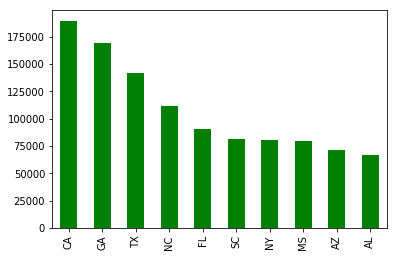

In [56]:
data['STATE'].value_counts().head(n=10).plot(kind='bar',color='green')
plt.show()

Text(0.5, 1.0, 'Frequency of Wildfires Over Time')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of Instances')

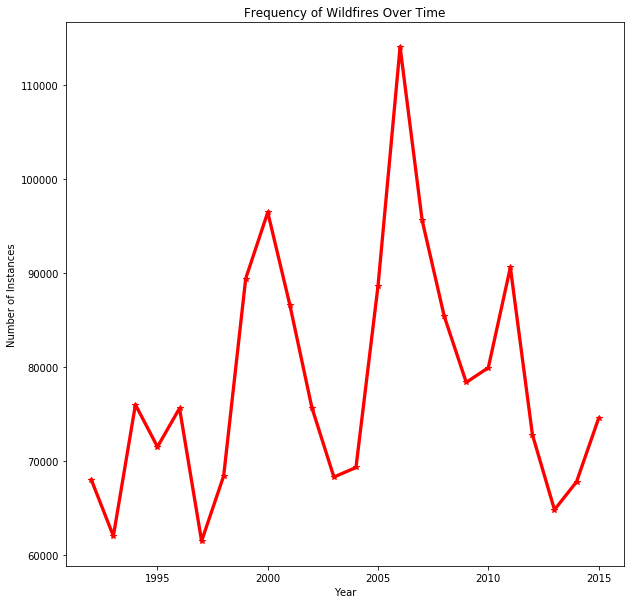

In [57]:
df_year = data[['FIRE_YEAR']]
df_year['FIRE_YEAR'].value_counts(sort=False).plot(kind="line",marker='*',figsize=(10,10), color='r', linewidth=3.3)
plt.title('Frequency of Wildfires Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Instances')
plt.show()

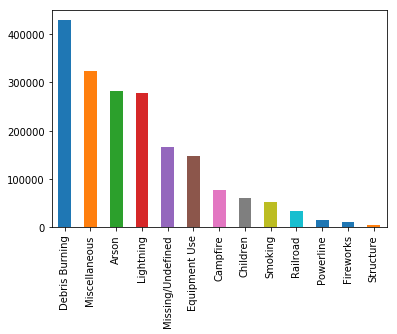

In [58]:
data["CAUSE_DESCR"].value_counts().plot(kind="bar")

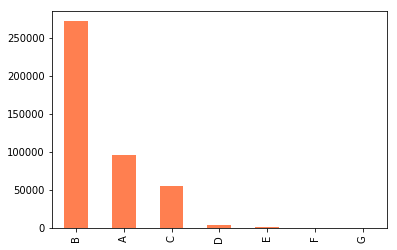

In [59]:
data_Burning = data[data['CAUSE_DESCR']=='Debris Burning']
data_Burning['FIRE_CLASS'].value_counts().plot(kind='bar',color='coral')
plt.show()

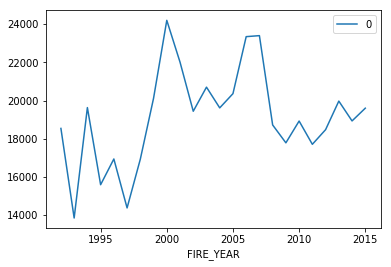

In [60]:
size_per_year=data.groupby(['FIRE_YEAR','FIRE_SIZE']).size().reset_index().groupby('FIRE_YEAR')[[0]].max()
size_per_year.plot()

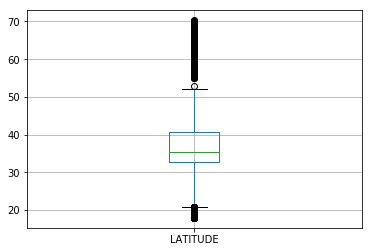

In [61]:
data.boxplot("LATITUDE")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017516A52EB8>]],
      dtype=object)

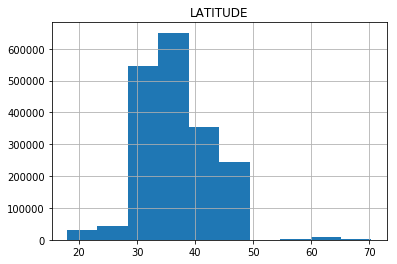

In [62]:
data.hist("LATITUDE")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000175160A0E10>,
      dtype=object)

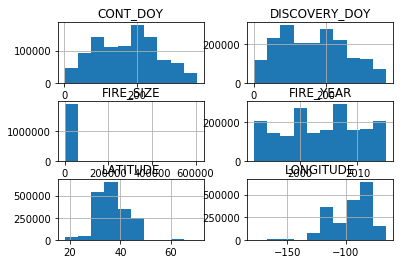

In [63]:
data.hist()

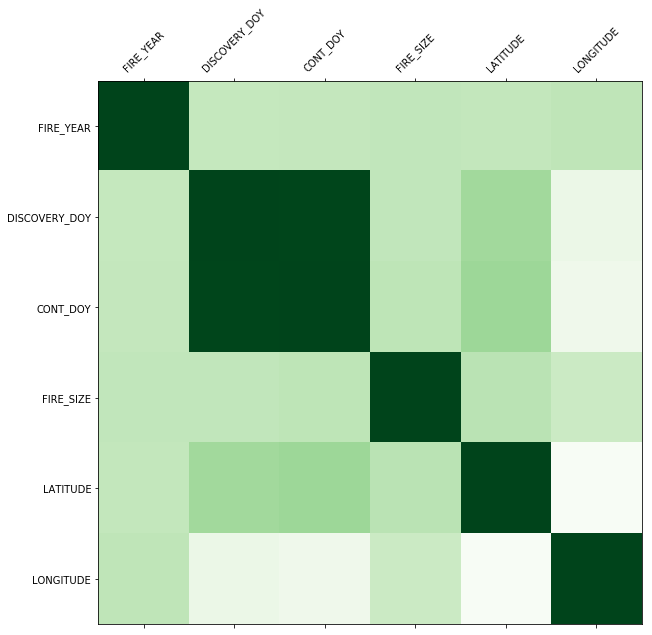

In [64]:
def plot_corr(df,size=10):
    corr = df.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Greens)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
    

    
plot_corr(data, size=10)

In [65]:
data.head()

,UNIT_NAME,FIRE_YEAR,DISCOVERY_DOY,CAUSE_DESCR,CONT_DOY,FIRE_SIZE,FIRE_CLASS,LATITUDE,LONGITUDE,STATE,Shape,DISC_DATE,CONTAIN_DATE,TOTAL_DAYS
0,Plumas National Forest,2005,33,Miscellaneous,33.0,0.10,A,40.036944,-121.005833,CA,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,2005-02-02,2005-02-02,0 days
1,Eldorado National Forest,2004,133,Lightning,133.0,0.25,A,38.933056,-120.404444,CA,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,2004-05-12,2004-05-12,0 days
2,Eldorado National Forest,2004,152,Debris Burning,152.0,0.10,A,38.984167,-120.735556,CA,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,2004-05-31,2004-05-31,0 days
3,Eldorado National Forest,2004,180,Lightning,185.0,0.10,A,38.559167,-119.913333,CA,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,2004-06-28,2004-07-03,5 days
4,Eldorado National Forest,2004,180,Lightning,185.0,0.10,A,38.559167,-119.933056,CA,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,2004-06-28,2004-07-03,5 days


In [67]:
data.describe()

,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,TOTAL_DAYS
count,1.880465e+06,1.880465e+06,988934.000000,1.880465e+06,1.880465e+06,1.880465e+06,988934
mean,2.003710e+03,1.647191e+02,172.656766,7.452016e+01,3.678121e+01,-9.570494e+01,1 days 05:36:33.612920
std,6.663099e+00,9.003891e+01,84.320348,2.497598e+03,6.139031e+00,1.671694e+01,15 days 14:51:12.093534
min,1.992000e+03,1.000000e+00,1.000000,1.000000e-05,1.793972e+01,-1.788026e+02,0 days 00:00:00
25%,1.998000e+03,8.900000e+01,102.000000,1.000000e-01,3.281860e+01,-1.103635e+02,0 days 00:00:00
50%,2.004000e+03,1.640000e+02,181.000000,1.000000e+00,3.545250e+01,-9.204304e+01,0 days 00:00:00
75%,2.009000e+03,2.300000e+02,232.000000,3.300000e+00,4.082720e+01,-8.229760e+01,0 days 00:00:00
max,2.015000e+03,3.660000e+02,366.000000,6.069450e+05,7.033060e+01,-6.525694e+01,4018 days 00:00:00


df=data.groupby("Day_Category")
print(df["FIRE_SIZE"].count())

In [68]:
#Create a new function:
def num_missing(x):
    return sum(x.isnull())

#Applying per column:
print("Missing values per column:")
## Check how many are missing by column, and then check which ones have any missing values
print(data.apply(num_missing, axis=0).where(lambda x : x != 0).dropna().head(20)) 
#axis=0 defines that function is to be applied on each column

Missing values per column:
CONT_DOY        891531.0
CONTAIN_DATE    891531.0
TOTAL_DAYS      891531.0
dtype: float64


In [69]:
print(data.dtypes)

UNIT_NAME                 object
FIRE_YEAR                  int64
DISCOVERY_DOY              int64
CAUSE_DESCR               object
CONT_DOY                 float64
FIRE_SIZE                float64
FIRE_CLASS                object
LATITUDE                 float64
LONGITUDE                float64
STATE                     object
Shape                     object
DISC_DATE         datetime64[ns]
CONTAIN_DATE      datetime64[ns]
TOTAL_DAYS       timedelta64[ns]
dtype: object


In [70]:
data.shape

(1880465, 14)

In [71]:
data = data.dropna()

In [72]:
#Create a new function:
def num_missing(x):
    return sum(x.isnull())

#Applying per column:
print("Missing values per column:")
## Check how many are missing by column, and then check which ones have any missing values
print(data.apply(num_missing, axis=0).where(lambda x : x != 0).dropna().head(20)) 
#axis=0 defines that function is to be applied on each column

Missing values per column:
Series([], dtype: float64)


In [73]:
print(data.dtypes)

UNIT_NAME                 object
FIRE_YEAR                  int64
DISCOVERY_DOY              int64
CAUSE_DESCR               object
CONT_DOY                 float64
FIRE_SIZE                float64
FIRE_CLASS                object
LATITUDE                 float64
LONGITUDE                float64
STATE                     object
Shape                     object
DISC_DATE         datetime64[ns]
CONTAIN_DATE      datetime64[ns]
TOTAL_DAYS       timedelta64[ns]
dtype: object


In [74]:
#trying to understand data by grouping by the fire class
df=data.groupby("FIRE_CLASS")
print(df["FIRE_CLASS"].count())

FIRE_CLASS
A    421865
B    429692
C    103618
D     15720
E      9016
F      5802
G      3221
Name: FIRE_CLASS, dtype: int64


In [78]:
# creating dummy variables
df_fireclass = pd.get_dummies(data, columns=['FIRE_CLASS'])
df_fireclass.head()

,UNIT_NAME,FIRE_YEAR,DISCOVERY_DOY,CAUSE_DESCR,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,Shape,DISC_DATE,CONTAIN_DATE,TOTAL_DAYS,FIRE_CLASS_A,FIRE_CLASS_B,FIRE_CLASS_C,FIRE_CLASS_D,FIRE_CLASS_E,FIRE_CLASS_F,FIRE_CLASS_G
0,Plumas National Forest,2005,33,Miscellaneous,33.0,0.10,40.036944,-121.005833,CA,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,2005-02-02,2005-02-02,0 days,1,0,0,0,0,0,0
1,Eldorado National Forest,2004,133,Lightning,133.0,0.25,38.933056,-120.404444,CA,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,2004-05-12,2004-05-12,0 days,1,0,0,0,0,0,0
2,Eldorado National Forest,2004,152,Debris Burning,152.0,0.10,38.984167,-120.735556,CA,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,2004-05-31,2004-05-31,0 days,1,0,0,0,0,0,0
3,Eldorado National Forest,2004,180,Lightning,185.0,0.10,38.559167,-119.913333,CA,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,2004-06-28,2004-07-03,5 days,1,0,0,0,0,0,0
4,Eldorado National Forest,2004,180,Lightning,185.0,0.10,38.559167,-119.933056,CA,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,2004-06-28,2004-07-03,5 days,1,0,0,0,0,0,0


In [79]:
# dropping one column of the dummy variables to have a baseline
df_fireclass = df_fireclass.drop('FIRE_CLASS_G',axis=1)
df_fireclass.head()

,UNIT_NAME,FIRE_YEAR,DISCOVERY_DOY,CAUSE_DESCR,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,Shape,DISC_DATE,CONTAIN_DATE,TOTAL_DAYS,FIRE_CLASS_A,FIRE_CLASS_B,FIRE_CLASS_C,FIRE_CLASS_D,FIRE_CLASS_E,FIRE_CLASS_F
0,Plumas National Forest,2005,33,Miscellaneous,33.0,0.10,40.036944,-121.005833,CA,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,2005-02-02,2005-02-02,0 days,1,0,0,0,0,0
1,Eldorado National Forest,2004,133,Lightning,133.0,0.25,38.933056,-120.404444,CA,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,2004-05-12,2004-05-12,0 days,1,0,0,0,0,0
2,Eldorado National Forest,2004,152,Debris Burning,152.0,0.10,38.984167,-120.735556,CA,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,2004-05-31,2004-05-31,0 days,1,0,0,0,0,0
3,Eldorado National Forest,2004,180,Lightning,185.0,0.10,38.559167,-119.913333,CA,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,2004-06-28,2004-07-03,5 days,1,0,0,0,0,0
4,Eldorado National Forest,2004,180,Lightning,185.0,0.10,38.559167,-119.933056,CA,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,2004-06-28,2004-07-03,5 days,1,0,0,0,0,0


In [80]:
df_fireclass.dtypes

UNIT_NAME                 object
FIRE_YEAR                  int64
DISCOVERY_DOY              int64
CAUSE_DESCR               object
CONT_DOY                 float64
FIRE_SIZE                float64
LATITUDE                 float64
LONGITUDE                float64
STATE                     object
Shape                     object
DISC_DATE         datetime64[ns]
CONTAIN_DATE      datetime64[ns]
TOTAL_DAYS       timedelta64[ns]
FIRE_CLASS_A               uint8
FIRE_CLASS_B               uint8
FIRE_CLASS_C               uint8
FIRE_CLASS_D               uint8
FIRE_CLASS_E               uint8
FIRE_CLASS_F               uint8
dtype: object

In [81]:
pd.options.mode.chained_assignment = None  # default='warn'

# Define our dependent variable
y_column = 'FIRE_YEAR'
y = df_fireclass[y_column]
# Define our independent variables
x_columns = ['FIRE_CLASS_A','FIRE_CLASS_B','FIRE_CLASS_C','FIRE_CLASS_D','FIRE_CLASS_E','FIRE_CLASS_F']
X = df_fireclass[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
model = sm.OLS(endog=y_train, exog=X_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              FIRE_YEAR   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     131.8
Date:                Tue, 03 Mar 2020   Prob (F-statistic):          1.84e-167
Time:                        11:55:07   Log-Likelihood:            -2.7010e+06
No. Observations:              791147   AIC:                         5.402e+06
Df Residuals:                  791140   BIC:                         5.402e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
FIRE_CLASS_A    -0.8708      0.146     -5.951   

In [83]:
df_cause = pd.get_dummies(df_fireclass, columns=['CAUSE_DESCR'])
df_cause.head()

,UNIT_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,Shape,DISC_DATE,CONTAIN_DATE,TOTAL_DAYS,FIRE_CLASS_A,FIRE_CLASS_B,FIRE_CLASS_C,FIRE_CLASS_D,FIRE_CLASS_E,FIRE_CLASS_F,CAUSE_DESCR_Arson,CAUSE_DESCR_Campfire,CAUSE_DESCR_Children,CAUSE_DESCR_Debris Burning,CAUSE_DESCR_Equipment Use,CAUSE_DESCR_Fireworks,CAUSE_DESCR_Lightning,CAUSE_DESCR_Miscellaneous,CAUSE_DESCR_Missing/Undefined,CAUSE_DESCR_Powerline,CAUSE_DESCR_Railroad,CAUSE_DESCR_Smoking,CAUSE_DESCR_Structure
0,Plumas National Forest,2005,33,33.0,0.10,40.036944,-121.005833,CA,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,2005-02-02,2005-02-02,0 days,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Eldorado National Forest,2004,133,133.0,0.25,38.933056,-120.404444,CA,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,2004-05-12,2004-05-12,0 days,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Eldorado National Forest,2004,152,152.0,0.10,38.984167,-120.735556,CA,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,2004-05-31,2004-05-31,0 days,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Eldorado National Forest,2004,180,185.0,0.10,38.559167,-119.913333,CA,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,2004-06-28,2004-07-03,5 days,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Eldorado National Forest,2004,180,185.0,0.10,38.559167,-119.933056,CA,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,2004-06-28,2004-07-03,5 days,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [84]:
df_cause = df_cause.drop('CAUSE_DESCR_Powerline',axis=1)
df_cause.head()

,UNIT_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,Shape,DISC_DATE,CONTAIN_DATE,TOTAL_DAYS,FIRE_CLASS_A,FIRE_CLASS_B,FIRE_CLASS_C,FIRE_CLASS_D,FIRE_CLASS_E,FIRE_CLASS_F,CAUSE_DESCR_Arson,CAUSE_DESCR_Campfire,CAUSE_DESCR_Children,CAUSE_DESCR_Debris Burning,CAUSE_DESCR_Equipment Use,CAUSE_DESCR_Fireworks,CAUSE_DESCR_Lightning,CAUSE_DESCR_Miscellaneous,CAUSE_DESCR_Missing/Undefined,CAUSE_DESCR_Railroad,CAUSE_DESCR_Smoking,CAUSE_DESCR_Structure
0,Plumas National Forest,2005,33,33.0,0.10,40.036944,-121.005833,CA,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,2005-02-02,2005-02-02,0 days,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,Eldorado National Forest,2004,133,133.0,0.25,38.933056,-120.404444,CA,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,2004-05-12,2004-05-12,0 days,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,Eldorado National Forest,2004,152,152.0,0.10,38.984167,-120.735556,CA,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,2004-05-31,2004-05-31,0 days,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,Eldorado National Forest,2004,180,185.0,0.10,38.559167,-119.913333,CA,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,2004-06-28,2004-07-03,5 days,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,Eldorado National Forest,2004,180,185.0,0.10,38.559167,-119.933056,CA,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,2004-06-28,2004-07-03,5 days,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [85]:
model = sm.OLS(endog=y_train, exog=X_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              FIRE_YEAR   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     131.8
Date:                Tue, 03 Mar 2020   Prob (F-statistic):          1.84e-167
Time:                        11:56:22   Log-Likelihood:            -2.7010e+06
No. Observations:              791147   AIC:                         5.402e+06
Df Residuals:                  791140   BIC:                         5.402e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
FIRE_CLASS_A    -0.8708      0.146     -5.951   

In [86]:
pd.options.mode.chained_assignment = None  # default='warn'

# Define our dependent variable
y_column = 'FIRE_YEAR'
y = df_cause[y_column]
# Define our independent variables
x_columns = ['CAUSE_DESCR_Arson','CAUSE_DESCR_Campfire','CAUSE_DESCR_Children','CAUSE_DESCR_Debris Burning',
            'CAUSE_DESCR_Equipment Use','CAUSE_DESCR_Fireworks','CAUSE_DESCR_Miscellaneous','CAUSE_DESCR_Missing/Undefined'
            ,'CAUSE_DESCR_Railroad','CAUSE_DESCR_Smoking','CAUSE_DESCR_Structure','CAUSE_DESCR_Lightning']
X = df_cause[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
model = sm.OLS(endog=y_train, exog=X_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              FIRE_YEAR   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     2734.
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:56:39   Log-Likelihood:            -2.6853e+06
No. Observations:              791147   AIC:                         5.371e+06
Df Residuals:                  791134   BIC:                         5.371e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
CAUSE_DESCR_Ar

In [88]:
# converting total days to integer
data['DAY']=data['TOTAL_DAYS'].apply(lambda x: x.days)

In [89]:
# converting total days to integer in the new df created above for running regression
df_cause['DAY']=df_cause['TOTAL_DAYS'].apply(lambda x: x.days)

In [90]:
# dividing the days in number of bins to convert to categories small , medium, large and xlarge
data["Day_Category"]=pd.cut(data["DAY"], bins=[-1,3,5,10,500],labels=['small','medium','large','xlarge'])
data.head()

,UNIT_NAME,FIRE_YEAR,DISCOVERY_DOY,CAUSE_DESCR,CONT_DOY,FIRE_SIZE,FIRE_CLASS,LATITUDE,LONGITUDE,STATE,Shape,DISC_DATE,CONTAIN_DATE,TOTAL_DAYS,DAY,Day_Category
0,Plumas National Forest,2005,33,Miscellaneous,33.0,0.10,A,40.036944,-121.005833,CA,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,2005-02-02,2005-02-02,0 days,0,small
1,Eldorado National Forest,2004,133,Lightning,133.0,0.25,A,38.933056,-120.404444,CA,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,2004-05-12,2004-05-12,0 days,0,small
2,Eldorado National Forest,2004,152,Debris Burning,152.0,0.10,A,38.984167,-120.735556,CA,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,2004-05-31,2004-05-31,0 days,0,small
3,Eldorado National Forest,2004,180,Lightning,185.0,0.10,A,38.559167,-119.913333,CA,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,2004-06-28,2004-07-03,5 days,5,medium
4,Eldorado National Forest,2004,180,Lightning,185.0,0.10,A,38.559167,-119.933056,CA,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,2004-06-28,2004-07-03,5 days,5,medium


In [91]:
df_cause["Day_Category"]=pd.cut(df_cause["DAY"], bins=[-1,3,5,10,500],labels=['small','medium','large','xlarge'])
df_cause.head()

,UNIT_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,Shape,DISC_DATE,CONTAIN_DATE,TOTAL_DAYS,FIRE_CLASS_A,FIRE_CLASS_B,FIRE_CLASS_C,FIRE_CLASS_D,FIRE_CLASS_E,FIRE_CLASS_F,CAUSE_DESCR_Arson,CAUSE_DESCR_Campfire,CAUSE_DESCR_Children,CAUSE_DESCR_Debris Burning,CAUSE_DESCR_Equipment Use,CAUSE_DESCR_Fireworks,CAUSE_DESCR_Lightning,CAUSE_DESCR_Miscellaneous,CAUSE_DESCR_Missing/Undefined,CAUSE_DESCR_Railroad,CAUSE_DESCR_Smoking,CAUSE_DESCR_Structure,DAY,Day_Category
0,Plumas National Forest,2005,33,33.0,0.10,40.036944,-121.005833,CA,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,2005-02-02,2005-02-02,0 days,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,small
1,Eldorado National Forest,2004,133,133.0,0.25,38.933056,-120.404444,CA,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,2004-05-12,2004-05-12,0 days,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,small
2,Eldorado National Forest,2004,152,152.0,0.10,38.984167,-120.735556,CA,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,2004-05-31,2004-05-31,0 days,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,small
3,Eldorado National Forest,2004,180,185.0,0.10,38.559167,-119.913333,CA,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,2004-06-28,2004-07-03,5 days,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,medium
4,Eldorado National Forest,2004,180,185.0,0.10,38.559167,-119.933056,CA,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,2004-06-28,2004-07-03,5 days,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,medium


In [92]:
pd.options.mode.chained_assignment = None  # default='warn'

# Define our dependent variable
y_column = 'DAY'
y = df_cause[y_column]
# Define our independent variables
x_columns = ['CAUSE_DESCR_Arson','CAUSE_DESCR_Campfire','CAUSE_DESCR_Children','CAUSE_DESCR_Debris Burning',
            'CAUSE_DESCR_Equipment Use','CAUSE_DESCR_Fireworks','CAUSE_DESCR_Miscellaneous','CAUSE_DESCR_Missing/Undefined'
            ,'CAUSE_DESCR_Railroad','CAUSE_DESCR_Smoking','CAUSE_DESCR_Structure','CAUSE_DESCR_Lightning']
X = df_cause[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
model = sm.OLS(endog=y_train, exog=X_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    DAY   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     298.4
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        12:00:00   Log-Likelihood:            -3.2838e+06
No. Observations:              791147   AIC:                         6.568e+06
Df Residuals:                  791134   BIC:                         6.568e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
CAUSE_DESCR_Ar

In [94]:
pd.options.mode.chained_assignment = None  # default='warn'

# Define our dependent variable
y_column = 'DAY'
y = df_cause[y_column]
# Define our independent variables
x_columns = ['CAUSE_DESCR_Arson','CAUSE_DESCR_Campfire','CAUSE_DESCR_Children','CAUSE_DESCR_Debris Burning',
            'CAUSE_DESCR_Equipment Use','CAUSE_DESCR_Fireworks','CAUSE_DESCR_Miscellaneous','CAUSE_DESCR_Missing/Undefined'
            ,'CAUSE_DESCR_Railroad','CAUSE_DESCR_Smoking','CAUSE_DESCR_Structure','CAUSE_DESCR_Lightning','FIRE_CLASS_A',
             'FIRE_CLASS_B','FIRE_CLASS_C','FIRE_CLASS_D','FIRE_CLASS_E','FIRE_CLASS_F']
X = df_cause[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
model = sm.OLS(endog=y_train, exog=X_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    DAY   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1030.
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        12:00:19   Log-Likelihood:            -3.2764e+06
No. Observations:              791147   AIC:                         6.553e+06
Df Residuals:                  791128   BIC:                         6.553e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
CAUSE_DESCR_Ar

In [96]:
data.dtypes

UNIT_NAME                 object
FIRE_YEAR                  int64
DISCOVERY_DOY              int64
CAUSE_DESCR               object
CONT_DOY                 float64
FIRE_SIZE                float64
FIRE_CLASS                object
LATITUDE                 float64
LONGITUDE                float64
STATE                     object
Shape                     object
DISC_DATE         datetime64[ns]
CONTAIN_DATE      datetime64[ns]
TOTAL_DAYS       timedelta64[ns]
DAY                        int64
Day_Category            category
dtype: object

In [97]:
df_cause.dtypes

UNIT_NAME                                 object
FIRE_YEAR                                  int64
DISCOVERY_DOY                              int64
CONT_DOY                                 float64
FIRE_SIZE                                float64
LATITUDE                                 float64
LONGITUDE                                float64
STATE                                     object
Shape                                     object
DISC_DATE                         datetime64[ns]
CONTAIN_DATE                      datetime64[ns]
TOTAL_DAYS                       timedelta64[ns]
FIRE_CLASS_A                               uint8
FIRE_CLASS_B                               uint8
FIRE_CLASS_C                               uint8
FIRE_CLASS_D                               uint8
FIRE_CLASS_E                               uint8
FIRE_CLASS_F                               uint8
CAUSE_DESCR_Arson                          uint8
CAUSE_DESCR_Campfire                       uint8
CAUSE_DESCR_Children

In [100]:
# dropping all the non-numeric columns 
data_dt=data.select_dtypes([np.number])
data_dt.head()

,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,TOTAL_DAYS,DAY
0,2005,33,33.0,0.10,40.036944,-121.005833,0 days,0
1,2004,133,133.0,0.25,38.933056,-120.404444,0 days,0
2,2004,152,152.0,0.10,38.984167,-120.735556,0 days,0
3,2004,180,185.0,0.10,38.559167,-119.913333,5 days,5
4,2004,180,185.0,0.10,38.559167,-119.933056,5 days,5


In [125]:
# defining x and y
y_column = 'FIRE_SIZE'
y = data_dt[y_column]
X = data_dt.drop([y_column,"TOTAL_DAYS","LATITUDE","LONGITUDE","CONT_DOY"], axis=1) 

In [126]:
# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
def train_score_regressor(sklearn_regressor, X_train, y_train, X_test, y_test, model_parameters, print_oob_score=False):
    # initializing the sklearn regressor 
    regressor = sklearn_regressor(**model_parameters)  
    # training the algorithm using the X_train dataset of features and y_train, the associated target features
    regressor.fit(X_train, y_train)
    y_pred1 = regressor.predict (X_train)
    y_pred2 = regressor.predict (X_test)
   
    # calculating the score of the predictive power on the training and testing dataset.
    print ('Train score: %.3f' % r2_score(y_train, y_pred1))
    print ('Test score: %.3f' % r2_score(y_test, y_pred2))
    # results
    print(regressor)
    return regressor

In [128]:
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X_train, 
                                          y_train=y_train, 
                                          X_test=X_test, 
                                          y_test=y_test, 
                                          model_parameters={'random_state':42})

Train score: 0.854
Test score: -0.821
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')


In [133]:
parameters = {"max_depth":8,
              'random_state':42}

# training and evaluating the model
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X_train, 
                                          y_train=y_train, 
                                          X_test=X_test, 
                                          y_test=y_test, 
                                          model_parameters=parameters)

Train score: 0.263
Test score: 0.040
DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')


In [134]:
parameters = {"max_depth":[6,7,8],
              "max_leaf_nodes":[4,5,6]}
decision_regressor= DecisionTreeRegressor(random_state=42)

# initializing GridSearch and then fit
regressor=GridSearchCV(decision_regressor,parameters)
regressor.fit(X_train, y_train)
regressor.best_estimator_.get_params()

C:\Users\mrunm\anaconda\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [6, 7, 8], 'max_leaf_nodes': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

{'criterion': 'mse',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': 6,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 42,
 'splitter': 'best'}

In [135]:
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X_train, 
                                          y_train=y_train, 
                                          X_test=X_test, 
                                          y_test=y_test, 
                                          model_parameters=regressor.best_estimator_.get_params())

Train score: 0.073
Test score: 0.080
DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=6, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')
